In [ ]:
import pandas as pd
import matplotlib.pylab as plt
import numpy as np
import math
from datetime import datetime
from scipy.stats import norm 

# data procesing

In [ ]:
notes = pd.read_csv('/work/data/df_notes_of_scholl_test.csv')
notes.columns = ['date','note','indicator','class','especial_type','bimester']
notes['date'] = pd.to_datetime(notes['date'])
notes['especial_type'] =  notes['especial_type'].replace(np.nan,'no')

In [ ]:
notes.head(1)

,date,note,indicator,class,especial_type,bimester
0,2022-01-09 14:41:47,37,1,lengua_castellana,dignostic,1


# anlisis

## indicators

In [ ]:
def ponderate_avg(avg,dig=None,bim=None):
    if (not dig and not bim) or (np.isnan(dig) and np.isnan(bim)) :
        return avg
    if not dig or np.isnan(dig) :
        dig = (avg*55+bim*20)/75
    elif not bim or np.isnan(bim):
        bim = (avg*55+dig*25)/80   

    return (avg*55 + dig*25 + bim*20)/100

def indicators_calculator(classe,notes = notes):
    filter_notes = notes.loc[(notes['class'] == classe) & (notes['especial_type'] == 'no')][['indicator','note','bimester']]

    indicators = filter_notes.groupby(['indicator','bimester']).mean()
    indicators = indicators.merge(filter_notes.groupby(['indicator','bimester']).std(),left_index=True, right_index=True)
    indicators.columns = ['normal_note_avg','note_std']

    special_notes = notes.loc[(notes['especial_type'] != 'no')]
    special_notes = special_notes.pivot(index=['indicator','bimester'], columns='especial_type', values='note')
    for special_note in ['dignostic','bimonthly']:
        try:
            special_notes[special_note]
        except KeyError:
            special_notes.insert(0,special_note,[0]*len(special_notes))
    indicators = indicators.join(special_notes)

    indicators['ponderate_avg'] = indicators.apply(lambda row: ponderate_avg(row['normal_note_avg'],row['dignostic'],row['bimonthly']),axis=1)

    indicators = indicators.reset_index(['indicator','bimester']).sort_values('bimester')
    

    return indicators

In [ ]:
indicators = indicators_calculator('lengua_castellana')
indicators

,indicator,bimester,normal_note_avg,note_std,bimonthly,dignostic,ponderate_avg
0,1,1,32.333333,16.308047,19.0,37.0,30.833333
2,2,1,29.000000,13.957077,37.0,45.0,34.600000
4,3,1,35.200000,6.679987,27.0,25.0,31.010000
6,4,1,31.000000,11.401754,29.0,22.0,28.350000
1,1,2,30.400000,12.685950,NaN,12.0,24.650000
3,2,2,30.000000,13.784049,NaN,45.0,34.687500
5,3,2,20.000000,7.314369,NaN,45.0,27.812500
7,4,2,30.692308,12.263663,NaN,44.0,34.850962


## notes distribution 

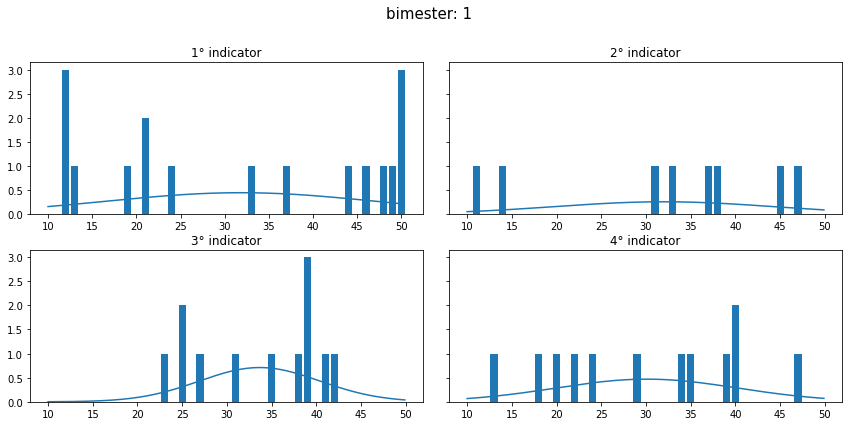

In [ ]:
def plot_distribution_indicator(classe,bimester, notes = notes):
    filter_notes = notes.loc[(notes['class'] == classe) & (notes['bimester'] == bimester)]

    indicators = filter_notes['indicator'].unique()
    indicators_gen = (i for i in [[0,0],[0,1],[1,0],[1,1]])
    
    fig, ax = plt.subplots(2,2,figsize=(12, 6),sharey=True)
    fig.tight_layout(h_pad=2) #avoid overlaping
    plt.subplots_adjust(top=0.85) #ovoid overlaping titile

    for indicator in indicators:
        ind_x_distribution = filter_notes.loc[(filter_notes['indicator'] == indicator)]['note'].values
        ubication = next(indicators_gen)

        #bars
        values, dist = np.unique(ind_x_distribution , return_counts=True)
        ax[ubication[0],ubication[1]].bar(values, dist)

        #distrivution
        dist = norm(ind_x_distribution.mean(), ind_x_distribution.std())
        x = np.arange(10, 50, 0.1)
        y = [dist.pdf(value)*len(ind_x_distribution) for value in x]
        ax[ubication[0],ubication[1]].plot(x,y) 

        ax[ubication[0],ubication[1]].set_title(f'{indicator}° indicator')

    fig.suptitle(f'bimester: {bimester}',fontsize=15)

plot_distribution_indicator('lengua_castellana',1)

## what i need to pass

In [ ]:
def how_much_to_pass(normal_avg,dig = 0,bim = 0):
    bim_dig_values = {'dig':0, 'bim':0}
    dig_notes = not ((dig == 0) or np.isnan(dig))
    bim_notes = not ((bim == 0) or np.isnan(bim))
    assert dig_notes and bim_notes == False, 'if dig and bim notes are already there you can do anything'

    try:
        if not dig_notes and not bim_notes:
            bim_dig_values['dig'] = bim_dig_values['bim'] = np.ceil((700-11*avg)/9)

        elif dig_notes and not bim_notes:
            bim_dig_values['bim'] = int(np.ceil((700-11*normal_avg-dig*5)/4))
        
        elif not dig_notes and bim_notes:
            bim_dig_values['dig'] = int(np.ceil((700-11*normal_avg-bim*4)/5))

        assert bim_dig_values['dig'] < 50 and bim_dig_values['bim'] < 50, 'the neded note exced the maximun posible note'

    except AssertionError as error:
        return 'is imposible to pass'

    bim_dig_values = {key:item for key, item in bim_dig_values.items() if item != 0}
    return bim_dig_values

def zptile(z_score):
    return .5 * (math.erf(z_score / 2 ** .5) + 1) *100

def prov_of_needed_note(notes_dictionay,indicator,notes=notes):
        min_prov = []
        max_prov = []
        provs = []

        notes_ind_data = notes.loc[(notes['indicator'] == indicator)] 
        error_magen = (1.96*notes_ind_data['note'].std())/len(notes_ind_data)**0.5 #revise it

        for key, item in notes_dictionay.items():

            z_score =  (item - notes_ind_data['note'].mean())/notes_ind_data['note'].std()
            prov = 100-zptile(z_score) #prov of achiving the note or a highter
            error = prov/100*error_magen

            provs.append(prov)
            min_prov.append(prov-error)
            max_prov.append(prov+error)


        provs = np.mean(provs)
        min_prov = round(np.mean(min_prov),2) #le saco el promedio o los multiplico
        max_prov = round(np.mean(max_prov),2)
        return f'{max_prov}%-{min_prov}%', [provs,error_magen]

def situation_analizer(indicators=indicators):
    situation = pd.DataFrame(columns=['def_note','pass','need_to_pass','need_note_provavility'] )

    for index, row in indicators.iterrows():
        situation_row = {'indicator':row['indicator'], 'bimester': row['bimester'], 'def_note':row['ponderate_avg'],  
        'pass':0 ,'need_to_pass': 'already_end'}

        dig_notes = not((row['dignostic'] == 0) or (np.isnan(row['dignostic'])))
        bim_notes = not((row['bimonthly'] == 0) or (np.isnan(row['bimonthly']))) 


        if dig_notes and bim_notes:
            situation_row['pass'] = 'yes' if situation_row['def_note'] >= 35 else 'no'

        else:
            situation_row['pass'] = 'currenly_yes' if situation_row['def_note'] >= 35 else 'currenly_no'
            situation_row['need_to_pass'] = how_much_to_pass(row['normal_note_avg'],row['dignostic'],row['bimonthly'])

            if type(situation_row['need_to_pass']) == dict:
                situation_row['need_note_provavility'], situation_row['provability_and_error'] = prov_of_needed_note(
                    situation_row['need_to_pass'],row['indicator'])

        situation = situation.append(situation_row, ignore_index=True)

    situation=situation.astype({'bimester':int,'indicator':int})
    situation = situation.set_index(['bimester','indicator'])

    #join situation to indicator
    indicators = indicators.set_index(['bimester','indicator'])
    indicators = indicators.join(situation)
    indicators = indicators.reset_index(['bimester','indicator'])

    return situation, indicators

In [ ]:
situation, full_report= situation_analizer()
situation.loc[(situation['need_note_provavility'] != 'already_end')]

def_note         pass          need_to_pass  \
bimester indicator                                                 
1        1          30.833333           no           already_end   
         2          34.600000           no           already_end   
         3          31.010000           no           already_end   
         4          28.350000           no           already_end   
2        1          24.650000  currenly_no  is imposible to pass   
         2          34.687500  currenly_no           {'bim': 37}   
         3          27.812500  currenly_no  is imposible to pass   
         4          34.850962  currenly_no           {'bim': 36}   

                   need_note_provavility  \
bimester indicator                         
1        1                           NaN   
         2                           NaN   
         3                           NaN   
         4                           NaN   
2        1                           NaN   
         2                 38.46%-33.44%   
         3                           NaN   
         4                 34.19%-31.32%   

                                     provability_and_error  
bimester indicator                                          
1        1                                             NaN  
         2                                             NaN  
         3                                             NaN  
         4                                             NaN  
2        1                                             NaN  
         2          [35.95152795544685, 6.974061607536882]  
         3                                             NaN  
         4          [32.75593150520844, 4.369083161103603]

In [ ]:
full_report.set_index(['bimester','indicator'])[['bimonthly','dignostic','ponderate_avg','pass']]

bimonthly  dignostic  ponderate_avg         pass
bimester indicator                                                  
1        1               19.0       37.0      30.833333           no
         2               37.0       45.0      34.600000           no
         3               27.0       25.0      31.010000           no
         4               29.0       22.0      28.350000           no
2        1                NaN       12.0      24.650000  currenly_no
         2                NaN       45.0      34.687500  currenly_no
         3                NaN       45.0      27.812500  currenly_no
         4                NaN       44.0      34.850962  currenly_no

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=50dbbd25-8c13-4c7b-a40f-860fb8cbc2c7' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>